In [5]:
from torch import device, cuda
import os
import torch
from tqdm import tqdm
import pandas as pd

from data_parser import adj_matrix, nodes
from models import CombinedModel, RETINA_MODEL
from image_parser import test_loader
from model_config_manager import ModelConfigManager

dev = device("cuda" if cuda.is_available() else "cpu")

In [2]:
# Create the ModelConfigManager and load configurations from YAML files
config_manager = ModelConfigManager()

# Get a specific configuration by model name
config_manager.set_model_config(RETINA_MODEL)

combined_model = CombinedModel(adj_matrix, neurons=nodes, model_config=config_manager.model_config)
combined_model.load_state_dict(torch.load(os.path.join("models", "model_vgg16_more_images_10_epochs.pth")), strict=False)
combined_model = combined_model.to(dev)
combined_model.eval()

C:\Users\eudald\Desktop\doctorat\codi\connectome\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\eudald\Desktop\doctorat\codi\connectome\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CombinedModel(
  (retina_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [3]:
# Test de model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(dev), labels.to(dev)
        outputs = combined_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

100%|██████████| 250/250 [00:39<00:00,  6.31it/s]


In [4]:
print(f"Accuracy on the {total} test images: {100 * correct / total}%")

Accuracy on the 2000 test images: 92.75000762939453%


In [6]:
# Test de model
correct = 0
total = 0
test_results_df = pd.DataFrame(columns=["Image", "Real Label", "Predicted Label", "Correct Prediction"])

j = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(dev), labels.to(dev)
        outputs = combined_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        # Convert the tensor values to CPU and numpy
        labels_cpu = labels.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()
        
        # Check if the prediction is correct
        correct_predictions = (predicted == labels)
        correct_cpu = correct_predictions.cpu().numpy()
        
        image_names = [a[0] for a in test_loader.dataset.dataset.samples[j * test_loader.batch_size: (j + 1) * test_loader.batch_size]]
        j += 1
        
        batch_df = pd.DataFrame({
            "Image": image_names,
            "Real Label": labels_cpu,
            "Predicted Label": predicted_cpu,
            "Correct Prediction": correct_cpu.astype(int)
        })
        
        # Append the batch DataFrame to the list
        test_results_df = pd.concat([test_results_df, batch_df], ignore_index=True)

100%|██████████| 250/250 [00:46<00:00,  5.38it/s]


In [7]:
# Assuming you have a DataFrame named 'test_results_df' with a 'image_filename' column
test_results_df['yellow'] = test_results_df['Image'].apply(lambda x: x.split('_')[1])
test_results_df['blue'] = test_results_df['Image'].apply(lambda x: x.split('_')[2])
test_results_df['weber_ratio'] = test_results_df.apply(lambda row: max(int(row['yellow']), int(row['blue'])) / min(int(row['yellow']), int(row['blue'])), axis=1)

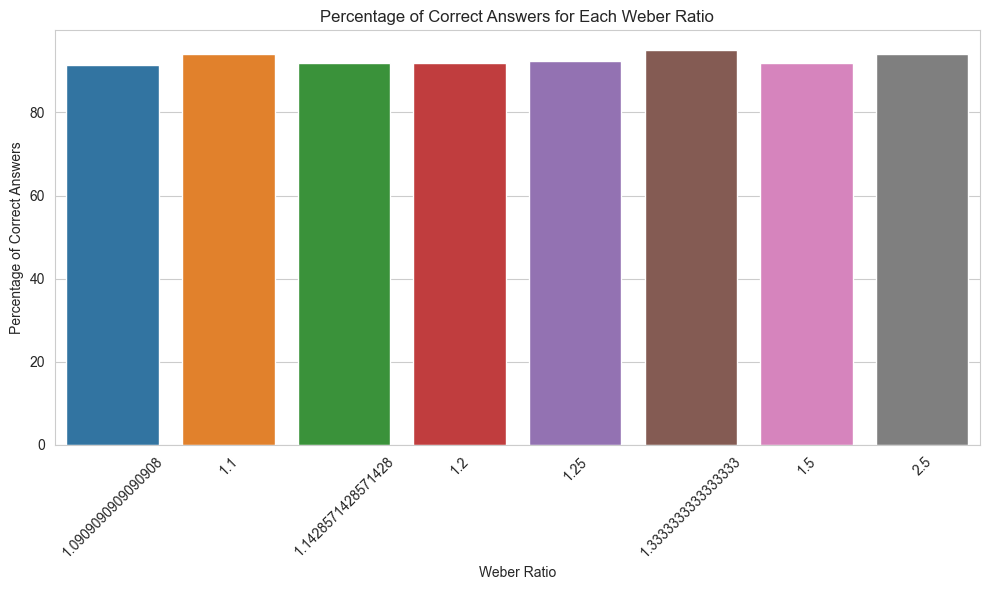

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage of correct answers for each Weber ratio
correct_percentage = test_results_df.groupby('weber_ratio')['Correct Prediction'].mean() * 100

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correct_percentage.index, y=correct_percentage.values)
plt.xlabel('Weber Ratio')
plt.ylabel('Percentage of Correct Answers')
plt.title('Percentage of Correct Answers for Each Weber Ratio')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()